In [1]:
# Import required libraries
import numpy as np
import pandas as pd
np.random.seed(8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import re
import warnings
warnings.filterwarnings('ignore')

# Read in train and test datasets from csv files
train = pd.read_csv('train.csv')
test_cm = pd.read_csv('test.csv')
test_lb = pd.read_csv('test_labels.csv')
# Merge test comments with test labels
test_all = pd.merge(test_cm, test_lb, on='id')
# Remove all test entries with labels equal to -1
test = test_all[test_all['toxic'] != -1]

Using TensorFlow backend.


In [2]:
X_train = train["comment_text"]
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"]
y_test = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [3]:
# Define vocabulary size
vocab = 100000
# Define maximum length of a comment
maxlen = 200
# Define embedding size which should equal the embedding size of the pre-trained word vectors
embed_size = 300

In [4]:
# Removing ip address
X_train = X_train.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
X_test = X_test.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
# Removing url link
X_train = X_train.apply(lambda x: re.sub("http://.*com","",x))
X_test = X_test.apply(lambda x: re.sub("http://.*com","",x))
# Removing username
X_train = X_train.apply(lambda x: re.sub("\[\[.*\]","",x))
X_test = X_test.apply(lambda x: re.sub("\[\[.*\]","",x))

In [5]:
# Filter out stop words
from nltk.corpus import stopwords

def filter_stop_words(sentences, stop_words):
    filtered = []
    for sentence in sentences:
        words = sentence.split()
        words_filtered = [word for word in words if word not in stop_words]
        filtered.append(" ".join(words_filtered))
    return filtered
 
stop_words = set(stopwords.words("english"))
 
# Comments in train
X_train_ = filter_stop_words(X_train, stop_words)
 
# Comments in test (excluding labels with -1 values)
X_test_ = filter_stop_words(X_test, stop_words)

In [6]:
# Tokenize the train dataset
t = text.Tokenizer(num_words=vocab)
t.fit_on_texts(list(X_train_))

In [7]:
# Convert both train and test datasets into sequences
X_train = t.texts_to_sequences(X_train_)
X_test = t.texts_to_sequences(X_test_)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
# Load pre-trained word vectors
EMBEDDING_FILE = 'crawl-300d-2M.vec'
embeddings_index = dict()
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s pre-trained words' % len(embeddings_index))

Loaded 2000000 pre-trained words


In [9]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab, embed_size))
for word, i in t.word_index.items():
    if i >= vocab: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# Define make_model function to create a CNN model
def make_model(k=[7], activation='relu', filters=100, Sdroprate=0.5, droprate=0.0):

    inp = Input(shape=(maxlen, ))
    x = Embedding(vocab, embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inp)
    x = SpatialDropout1D(Sdroprate)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv = dict()
    maxpool = dict()
    for h in k:
        conv[h] = Conv2D(filters, kernel_size=(h, embed_size), activation=activation)(x)
        maxpool[h] = MaxPool2D(pool_size=(maxlen - h + 1, 1))(conv[h])
        
    if len(k) == 1:
        y = maxpool[h]
    else:
        y = Concatenate(axis=1)([pool for key,pool in maxpool.items()])
    
    y = Flatten()(y)
    y = Dropout(droprate)(y)

    outp = Dense(6, activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
# Generate the model based on the default parameters
model = make_model()
# Print out the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 300, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 1, 100)       210100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
__________

In [11]:
# Define the cross validation split
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits = 1, test_size = 0.1)

In [15]:
scoring = {'AUC': 'roc_auc'}

#gs = GridSearchCV(LogisticRegression(), return_train_score=True,
#                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

In [16]:
# Wrap Keras model with KerasClassifier so that it can be used in Sklearn GridSearchCV
# Generate a GridSearchCV instance with the parameters to be tuned
# This is a starting model and we try to check which activation function performs better

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
my_classifier = KerasClassifier(make_model, verbose=1)

validator = GridSearchCV(my_classifier, return_train_score=True, param_grid={'k': [[7]],
                                                    'activation': ['relu'],
                                                   'filters': [100],
                                                   'Sdroprate':[0.0,0.1,0.2,0.3,0.4,0.5,0.6],
                                                   'droprate': [0.00],
                                                   'epochs': [3],
                                                   'batch_size': [128]},
                                                    cv = cv, 
                                                    scoring = scoring,
                                                    refit='AUC',
                                                    verbose=10)

In [17]:
# Run the Grid Search
grid_result = validator.fit(x_train, y_train)

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV] Sdroprate=0.0, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
143613/143613 [==============================] - 611s 4ms/step - loss: 0.0612 - acc: 0.9797
Epoch 2/3
143613/143613 [==============================] - 610s 4ms/step - loss: 0.0415 - acc: 0.9841
Epoch 3/3
143613/143613 [==============================] - 300s 2ms/step
[CV]  Sdroprate=0.0, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.9850604169985359, total=31.1min
[CV] Sdroprate=0.1, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 36.1min remaining:    0.0s


Epoch 1/3
143613/143613 [==============================] - 661s 5ms/step - loss: 0.0623 - acc: 0.9795
Epoch 2/3
143613/143613 [==============================] - 662s 5ms/step - loss: 0.0432 - acc: 0.9836
Epoch 3/3
143613/143613 [==============================] - 303s 2ms/step
[CV]  Sdroprate=0.1, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.9858418354769408, total=33.7min
[CV] Sdroprate=0.2, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 74.8min remaining:    0.0s


Epoch 1/3
143613/143613 [==============================] - 661s 5ms/step - loss: 0.0632 - acc: 0.9792
Epoch 2/3
143613/143613 [==============================] - 658s 5ms/step - loss: 0.0450 - acc: 0.9831
Epoch 3/3
143613/143613 [==============================] - 302s 2ms/step
[CV]  Sdroprate=0.2, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.9841489687288684, total=33.5min
[CV] Sdroprate=0.3, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 113.3min remaining:    0.0s


Epoch 1/3
143613/143613 [==============================] - 663s 5ms/step - loss: 0.0660 - acc: 0.9785
Epoch 2/3
143613/143613 [==============================] - 655s 5ms/step - loss: 0.0471 - acc: 0.9826
Epoch 3/3
143613/143613 [==============================] - 300s 2ms/step
[CV]  Sdroprate=0.3, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.9851965478793555, total=33.4min
[CV] Sdroprate=0.4, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 151.8min remaining:    0.0s


Epoch 1/3
143613/143613 [==============================] - 656s 5ms/step - loss: 0.0660 - acc: 0.9785
Epoch 2/3
143613/143613 [==============================] - 655s 5ms/step - loss: 0.0482 - acc: 0.9821
Epoch 3/3
143613/143613 [==============================] - 306s 2ms/step
[CV]  Sdroprate=0.4, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.985502736442364, total=33.4min
[CV] Sdroprate=0.5, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 190.2min remaining:    0.0s


Epoch 1/3
143613/143613 [==============================] - 664s 5ms/step - loss: 0.0700 - acc: 0.9779
Epoch 2/3
143613/143613 [==============================] - 662s 5ms/step - loss: 0.0509 - acc: 0.9813
Epoch 3/3
143613/143613 [==============================] - 305s 2ms/step
[CV]  Sdroprate=0.5, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.9838137268869916, total=33.8min
[CV] Sdroprate=0.6, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7] 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 229.1min remaining:    0.0s


Epoch 1/3
143613/143613 [==============================] - 660s 5ms/step - loss: 0.0732 - acc: 0.9771
Epoch 2/3
143613/143613 [==============================] - 656s 5ms/step - loss: 0.0541 - acc: 0.9805
Epoch 3/3
143613/143613 [==============================] - 302s 2ms/step
[CV]  Sdroprate=0.6, activation=relu, batch_size=128, droprate=0.0, epochs=3, filters=100, k=[7], AUC=0.984241910155563, total=33.4min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 267.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 267.6min finished


Epoch 1/3
159571/159571 [==============================] - 730s 5ms/step - loss: 0.0595 - acc: 0.9802
Epoch 2/3
159571/159571 [==============================] - 732s 5ms/step - loss: 0.0431 - acc: 0.9835
Epoch 3/3
159571/159571 [==============================] - 736s 5ms/step - loss: 0.0372 - acc: 0.9856


In [28]:
print("Best score: %f with %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_AUC']
stds = grid_result.cv_results_['std_test_AUC']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Get the best model
best_model = validator.best_estimator_.model

Best score: 0.985842 with {'Sdroprate': 0.1, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.985060 (0.000000) with: {'Sdroprate': 0.0, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.985842 (0.000000) with: {'Sdroprate': 0.1, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.984149 (0.000000) with: {'Sdroprate': 0.2, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.985197 (0.000000) with: {'Sdroprate': 0.3, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.985503 (0.000000) with: {'Sdroprate': 0.4, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.983814 (0.000000) with: {'Sdroprate': 0.5, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
0.9842

In [27]:
grid_result.cv_results_

{'mean_fit_time': array([1830.68350196, 1985.22723007, 1978.01516294, 1971.70006585,
        1968.67799401, 1994.03285599, 1972.77696991]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([33.46673393, 33.79035687, 33.80706811, 33.62743402, 33.72192717,
        34.20413089, 33.87889004]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0.]),
 'param_Sdroprate': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_batch_size': masked_array(data=[128, 128, 128, 128, 128, 128, 128],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_

In [30]:
param_grid={'k': [[7]],
                                                    'activation': ['relu'],
                                                   'filters': [100],
                                                   'Sdroprate':[0.0,0.1,0.2,0.3,0.4,0.5,0.6],
                                                   'droprate': [0.00],
                                                   'epochs': [3],
                                                   'batch_size': [128]}

In [29]:
# Perform prediction with unseen test dataset with the best model
y_pred = best_model.predict(x_test, batch_size=256)

In [31]:
# Calculate the roc_auc score
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred)
print("\n roc_auc score for keras model: %.6f \n" % (score))


 roc_auc score for keras model: 0.976943 



In [ ]:
# Generate a summary report for the best model architecture
best_model.summary()

In [34]:
max(param_grid['Sdroprate'])

0.6

best params: <keras.wrappers.scikit_learn.KerasClassifier object at 0x1a5c67cb70>
best params: {'Sdroprate': 0.1, 'activation': 'relu', 'batch_size': 128, 'droprate': 0.0, 'epochs': 3, 'filters': 100, 'k': [7]}
best score: 0.9858418354769408
[0.  0.1 0.2 0.3 0.4 0.5 0.6]
AUC g
train --
[0.99505697 0.99484081 0.99454063 0.99330888 0.99259262 0.99092076
 0.98966601]
[0. 0. 0. 0. 0. 0. 0.]
test -
[0.98506042 0.98584184 0.98414897 0.98519655 0.98550274 0.98381373
 0.98424191]
[0. 0. 0. 0. 0. 0. 0.]
1
0.9858418354769408


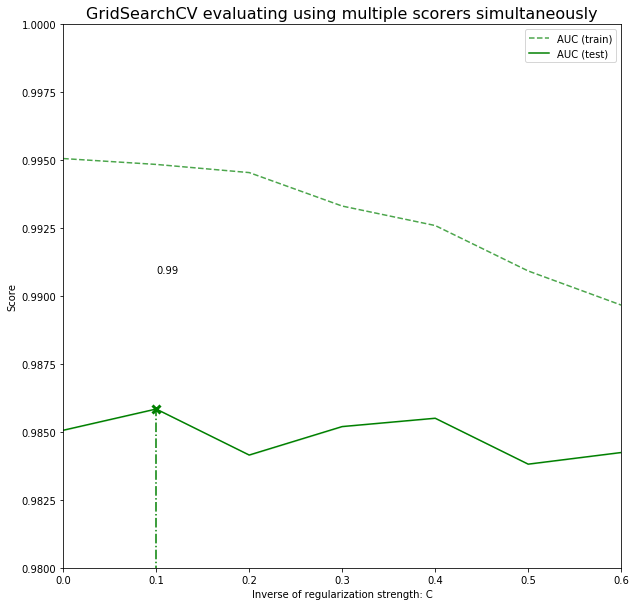

In [59]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
results = grid_result.cv_results_

print('='*20)
print("best params: " + str(grid_result.best_estimator_))
print("best params: " + str(grid_result.best_params_))
print('best score:', grid_result.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, max(param_grid['Sdroprate']))
ax.set_ylim(0.98, 1.00)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_Sdroprate'].data, dtype=float)
print(X_axis)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    print(scorer, color)
    for sample, style in (('train', '--'), ('test', '-')):
        print(sample, style)
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        print(sample_score_mean)
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        print(sample_score_std)
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    print(best_index)
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
    print(best_score)   
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()